## Optimizing Manufacturing Process 
(Here the target is time, but the same can be applied for any target metric i.e. yield, quality, process etc)

In [71]:
# Import statements
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt

from tqdm import tqdm
import itertools
import glob
import regex as re
import pickle
import shap

import warnings
warnings.simplefilter("ignore")
pd.set_option('display.max_rows',None)
pd.set_option('display.max_columns',None)

from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error, make_scorer
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.ensemble import AdaBoostRegressor
from sklearn import tree
#from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import VotingRegressor
from sklearn.feature_selection import VarianceThreshold

In [72]:
files=glob.glob('T047/*.csv')
files=[file for file in files if '~' not in file]
print("# of files to be processed ", len(files))
#print(files)

# of files to be processed  19


In [73]:
raw_data = pd.DataFrame()
count = 0

for file in tqdm(files):
    temp = pd.read_csv(file)
    raw_data = pd.concat([raw_data, temp], axis=0)
    count = count+1
print('done')

raw_data.columns = ['operator', 'date', 'time','batch_id','product','lot','inlet_temp_set','inlet_temp_act','exhaust_temp_set','exhaust_temp_act','pan_speed_set','pan_speed_act','atm_air_set','atm_air_act','spray_pump_speed_set','spray_pump_speed_act','spray_rate_act','activity']
#raw_data.head()

100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:03<00:00,  5.61it/s]

done


In [74]:
#print(raw_data['product'].value_counts())
raw_data = raw_data.dropna(subset=['product'])
raw_data = raw_data[raw_data['product'].str.contains("31004737",case=False)]
#print(raw_data['activity'].value_counts())
#print(raw_data['product'].value_counts())
#print(raw_data['lot'].value_counts())
raw_data = raw_data[raw_data['activity'].str.contains("Manual Mode",case=False)]

raw_data.loc[raw_data["lot"] == ' A', "lot"] = 'A'
raw_data['batch_id'] = raw_data['batch_id']+ "_" +raw_data['lot']
                                    
raw_data['timestamp'] = raw_data['date'].astype(str) +' '+ raw_data['time'].astype(str)
raw_data = raw_data.apply(pd.to_numeric, errors='ignore')
raw_data['timestamp'] = pd.to_datetime(raw_data['timestamp'])
                                    
raw_data.drop(['operator','date','time','lot','product','activity'], axis = 1, inplace=True)
raw_data.drop(['inlet_temp_act','exhaust_temp_act','pan_speed_act','spray_pump_speed_act','atm_air_act'], axis = 1, inplace=True)

raw_data.reset_index(drop=True, inplace=True)
#raw_data.head()

In [75]:
data = raw_data.copy()
data.loc[data["spray_rate_act"] >= 300, "spray_rate_act"] = 250
data = data[data['spray_rate_act']>=100]

data.describe(percentiles= [0.05,0.1,0.2,0.25,0.3,0.4,0.5,0.6,0.7,0.75,0.8,0.9,0.95,1])

100%|██████████████████████████████████████████████████████████████████████████████████| 58/58 [00:00<00:00, 70.33it/s]


Batches remaining  57
Batches eliminated  []
count     57.000000
mean     228.138889
std       12.433240
min      202.233333
5%       210.000000
10%      215.200000
20%      219.400000
25%      222.000000
30%      222.403333
40%      223.166667
50%      225.000000
60%      228.000000
70%      230.200000
75%      238.000000
80%      239.800000
90%      242.400000
95%      254.400000
100%     259.000000
max      259.000000
Name: final_duration_in_mins, dtype: float64
Expacted impact on cycle time in minutes: 19.26666666666671
Target cycle time: 208.87222222222218
Avg cycle time (before intervention) 228.13888888888889


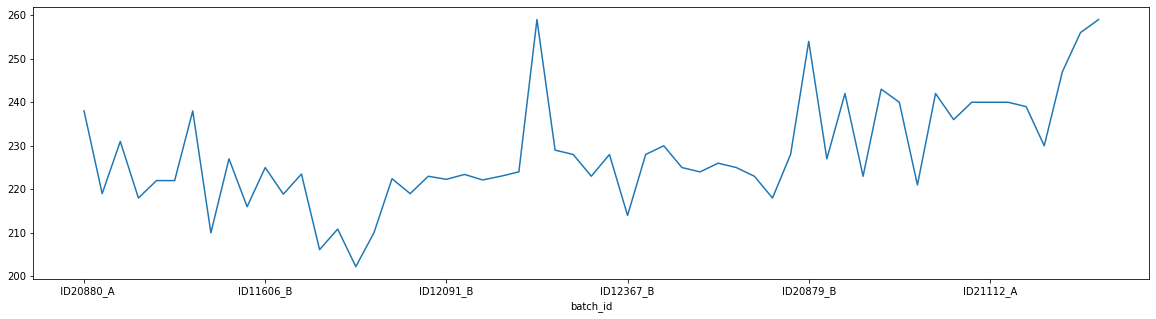

In [54]:
start_time_df=data.groupby('batch_id')['timestamp'].min().reset_index()
start_time_df.columns=['batch_id','start_time']
end_time_df=data.groupby('batch_id')['timestamp'].max().reset_index()
end_time_df.columns=['batch_id','end_time']
duration_df=start_time_df.merge(end_time_df, on=['batch_id'], validate='1:1')

final_df = duration_df
final_df['duration_in_mins']=(final_df['end_time']-final_df['start_time'])/np.timedelta64(1,'m')

##  Removing Long breaks (>5 Minutes) if exixts from the cycle time 

break_duration = {}

for batch in tqdm(data['batch_id'].unique()):
    temp_df = data[data.batch_id==batch].sort_values('timestamp').reset_index(drop=True)
    
    temp_df['timestamp_shifted']=temp_df['timestamp'].shift(1)
    temp_df['break_duration']=(temp_df['timestamp']-temp_df['timestamp_shifted'])/np.timedelta64(1,'m')
    temp_df.drop('timestamp_shifted',axis=1,inplace=True)
    duration = temp_df[temp_df['break_duration']>5]['break_duration'].sum()
    break_duration[batch] = duration
    
break_df=pd.DataFrame(break_duration,index=range(0,30,1)).T[0].reset_index()
break_df.columns=['batch_id','break_5M_above']
break_df.sort_values('batch_id').index

final_df=final_df.merge(break_df, on='batch_id', how='inner')
final_df['final_duration_in_mins'] = final_df['duration_in_mins']-final_df['break_5M_above']
time = final_df

# Outlier Treatment
final_df_with_no_outliers=final_df[final_df['final_duration_in_mins']>=100]
final_df_with_no_outliers=final_df_with_no_outliers[final_df_with_no_outliers['final_duration_in_mins']<=500]
print("Batches remaining ", final_df_with_no_outliers['batch_id'].nunique())
print("Batches eliminated ", [b for b in final_df['batch_id'].unique().tolist() if b not in final_df_with_no_outliers['batch_id'].unique().tolist()])

print(final_df_with_no_outliers['final_duration_in_mins'].describe(percentiles=[0.05,0.1,0.2,0.25,0.3,0.4,0.5,0.6,0.7,0.75,0.8,0.9,0.95,1]))

plt.figure(figsize=(20,5))
final_df_with_no_outliers.set_index('batch_id')['final_duration_in_mins'].plot()
time = final_df_with_no_outliers.copy()
### Impact calculation
time['deciles'] = pd.qcut(time.final_duration_in_mins, 10, duplicates='drop',labels=False)
time = time.sort_values('deciles')
target_cycle_time = time[time['deciles']==0]['final_duration_in_mins'].mean()
avg_cycle_time = time["final_duration_in_mins"].mean()
impact = avg_cycle_time-target_cycle_time
print('Expacted impact on cycle time in minutes:', impact)
print('Target cycle time:', target_cycle_time)
print('Avg cycle time (before intervention)', time["final_duration_in_mins"].mean())
time.drop(['start_time','end_time','duration_in_mins','break_5M_above','deciles'], axis=1, inplace=True)

In [ ]:
#Sample code to generalize recipie based modelling, (not fully implemented)...

#temp=data.groupby([pd.Grouper(key='batch_id'),pd.Grouper(key="timestamp", freq="30Min", offset="0m", label="right")])[features].mean()
#temp.head(1)

In [63]:
features=data.columns.tolist()
unwanted_features=['timestamp','batch_id']
features=[f for f in features if f not in unwanted_features]
print("# of features ", len(features))

# Min of the features
min_features=data.groupby('batch_id')[features].min().reset_index()
min_features=min_features.set_index('batch_id')
min_features.columns = [str(col) + '_min' for col in min_features.columns]

# 25percentile of the features
q1_features=data.groupby('batch_id')[features].quantile(0.25).reset_index()
q1_features=q1_features.set_index('batch_id')
q1_features.columns = [str(col) + '_q1' for col in t25_features.columns]

# Mode/Median of the features
mode_features=data.groupby('batch_id')[features].median().reset_index()
mode_features=mode_features.set_index('batch_id')
mode_features.columns = [str(col) + '_mode' for col in mode_features.columns]

# 75percentile of the features
q3_features=data.groupby('batch_id')[features].quantile(0.75).reset_index()
q3_features=q3_features.set_index('batch_id')
q3_features.columns = [str(col) + '_q3' for col in t75_features.columns]

# Max of the features
max_features=data.groupby('batch_id')[features].max().reset_index()
max_features=max_features.set_index('batch_id')
max_features.columns = [str(col) + '_max' for col in max_features.columns]

# Feature df
feature_df=min_features.reset_index().merge(q1_features.reset_index(), on=['batch_id'])
feature_df=feature_df.merge(mode_features.reset_index(), on=['batch_id'])
feature_df=feature_df.merge(q3_features.reset_index(), on=['batch_id'])
feature_df=feature_df.merge(max_features.reset_index(), on=['batch_id'])
feature_df=feature_df.set_index('batch_id')

features=feature_df.columns.tolist()
print("# of features ", len(features))

# of features  6
# of features  30


In [64]:
ff = feature_df.copy()
print(ff.shape)

num_colums = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numerical_columns = list(ff.select_dtypes(include=num_colums).columns)
ff = ff[numerical_columns]
print(ff.shape)

constant_filter = VarianceThreshold(threshold=0)
constant_filter.fit(ff)
len(ff.columns[constant_filter.get_support()])
constant_columns = [column for column in ff.columns
                    if column not in ff.columns[constant_filter.get_support()]]
ff.drop(labels=constant_columns, axis=1, inplace=True)
print(constant_columns)
print(ff.shape)

qconstant_filter = VarianceThreshold(threshold=0.01)
qconstant_filter.fit(ff)
len(ff.columns[qconstant_filter.get_support()])
qconstant_columns = [column for column in ff.columns
                    if column not in ff.columns[qconstant_filter.get_support()]]
ff.drop(labels=qconstant_columns, axis=1, inplace=True)
print(qconstant_columns)
print(ff.shape)

ff_T = ff.T
unique_features = ff_T.drop_duplicates(keep='first').T
print(ff.shape)

correlated_features = set()
correlation_matrix = ff.corr()
for i in range(len(correlation_matrix .columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > 0.9:
            colname = correlation_matrix.columns[i]
            correlated_features.add(colname)
#ff.drop(labels=correlated_features, axis=1, inplace=True)
print(correlated_features)

ff.reset_index(inplace=True)
data=ff.copy()
print(data.shape)
data.head(1)

(57, 30)
(57, 30)
['spray_pump_speed_set_min', 'spray_pump_speed_set_mean_q1', 'spray_pump_speed_set_mode', 'spray_pump_speed_set_max']
(57, 26)
[]
(57, 26)
(57, 26)
{'atm_air_set_max', 'inlet_temp_set_max', 'inlet_temp_set_mean_q3', 'inlet_temp_set_mode', 'exhaust_temp_set_mode'}
(57, 27)


,batch_id,inlet_temp_set_min,exhaust_temp_set_min,pan_speed_set_min,atm_air_set_min,spray_rate_act_min,inlet_temp_set_mean_q1,exhaust_temp_set_mean_q1,pan_speed_set_mean_q1,atm_air_set_mean_q1,spray_rate_act_mean_q1,inlet_temp_set_mode,exhaust_temp_set_mode,pan_speed_set_mode,atm_air_set_mode,spray_rate_act_mode,inlet_temp_set_mean_q3,exhaust_temp_set_mean_q3,pan_speed_set_mean_q3,atm_air_set_mean_q3,spray_pump_speed_set_mean_q3,spray_rate_act_mean_q3,inlet_temp_set_max,exhaust_temp_set_max,pan_speed_set_max,atm_air_set_max,spray_rate_act_max
0,ID20880_A,60.0,45.0,1.2,2.6,110.0,61.0,45.0,1.7,2.8,180.0,62.0,45.0,2.1,2.9,180.0,62.0,45.0,2.6,3.1,7.0,190.0,63.0,45.0,2.6,3.2,240.0


In [ ]:
df = time.merge(data,on=['batch_id'], validate='1:1')
df.head()
plt.figure(figsize = (25,25))
sns.heatmap(df.corr(), annot=True)

In [66]:
df.drop(['batch_id'],axis=1,inplace=True)
y=df['final_duration_in_mins']
df.drop(['final_duration_in_mins'],axis=1,inplace=True)
X=df

xtrain, xtest, ytrain, ytest = train_test_split(X, y, test_size = 0.15)
print("Train shape X ", xtrain.shape)
print("Train shape Y ", ytrain.shape)
print("Test shape X ", xtest.shape)
print("Test shape Y ", ytest.shape)

Train shape X  (48, 26)
Train shape Y  (48,)
Test shape X  (9, 26)
Test shape Y  (9,)


In [67]:
def rmse_calc(predictions, test_labels):
    return np.sqrt(((predictions - test_labels) ** 2).mean())
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    errors = abs(predictions - test_labels)
    mape = 100 * np.mean(errors / test_labels)
    accuracy = 100 - mape
    rmse = rmse_calc(predictions, test_labels)
    r2 = r2_score(test_labels, predictions)
    print('Model Performance')
    print('Average Error: ',np.mean(errors))
    print('Accuracy:', accuracy)
    print('MAPE:', mape)
    print('RMSE:', rmse)
    print('r2:',r2)
    print('Min and Max errors: ', errors.min(), errors.max())
    
n_estimators = [10,30,50,100]
max_depth =[3,4,5,6,7,8,9]
random_grid = {'n_estimators': n_estimators,
               'max_depth': max_depth,
            'bootstrap':[True,False],
            'oob_score':[True],
            'random_state':[42],
            'ccp_alpha':[0.05,0.2,0.3,0.5,0.6],
            'criterion':['mae','mse']}

In [25]:
models = [
    LinearRegression(),
#    LogisticRegression(),
    svm.SVR(),
#    HistGradientBoostingRegressor()
    Lasso(alpha=0.1),
    Ridge(),
    AdaBoostRegressor(random_state=42),
    GradientBoostingRegressor(),
    RandomForestRegressor(),
    tree.DecisionTreeRegressor()
]

metrics = pd.DataFrame(columns=['Model','Accuracy','Avg Error','r2'])
count=0

for model in models:
    model.fit(xtrain, ytrain)
    #evaluate(model, xtest, ytest)
    predictions = model.predict(xtest)
    errors = abs(predictions - ytest)
    mape = 100 * np.mean(errors / ytest)
    accuracy = 100 - mape
    metrics.at[count,'Model']=model
    metrics.at[count,'Accuracy']=accuracy
    metrics.at[count,'Avg Error']=np.mean(errors)
    metrics.at[count,'r2']=r2_score(ytest, predictions)
    count = count+1
    
metrics.head(10)

,Model,Accuracy,Avg Error,r2
0,LinearRegression(),94.340757,13.72369,0.015652
1,SVR(),93.443986,16.412315,-0.809919
2,Lasso(alpha=0.1),96.101431,9.52165,0.409934
3,Ridge(),96.377433,8.839617,0.473211
4,"(DecisionTreeRegressor(max_depth=3, random_sta...",95.142252,12.032166,-0.040314
5,([DecisionTreeRegressor(criterion='friedman_ms...,95.323783,11.687109,-0.100991
6,"(DecisionTreeRegressor(max_features='auto', ra...",94.958452,12.486074,-0.093403
7,DecisionTreeRegressor(),96.88496,7.635185,0.464951


In [ ]:
#model = rf_random.best_estimator_
explainer = shap.TreeExplainer(model,)
shap_values = explainer.shap_values(X, check_additivity=False)
shap_values_df = pd.DataFrame(shap_values, columns=X.columns, index=X.index)
shap_values_summary = pd.DataFrame(shap_values_df.abs().mean(), columns=["abs_mean_shap"])
shap_values_summary = shap_values_summary.sort_values(by="abs_mean_shap", ascending=False)


#feature_imp.sort_values(by=['Scores'], ascending=[False]).to_csv('feature_importance.csv')

top_shap_features = shap_values_summary.index.tolist()
for feature in top_shap_features:
    fig = shap.dependence_plot(
        feature,
        shap_values,
        X,
        interaction_index=None,
        alpha=1,
        dot_size=20,
        color="purple",
        show=False,
    )
    plt.title(feature, fontsize=15)
    plt.xlabel('')
    plt.ylabel('')
    plt.title(feature)
    fname = feature.replace('/','_').replace('*','').replace("(","_").replace(")","_") + ".png"
    plt.savefig('plots - Copy/'+fname+'.png',bbox_inches='tight')